# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [12]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline
import random
import check_test
from plot_utils import plot_values

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [2]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [3]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

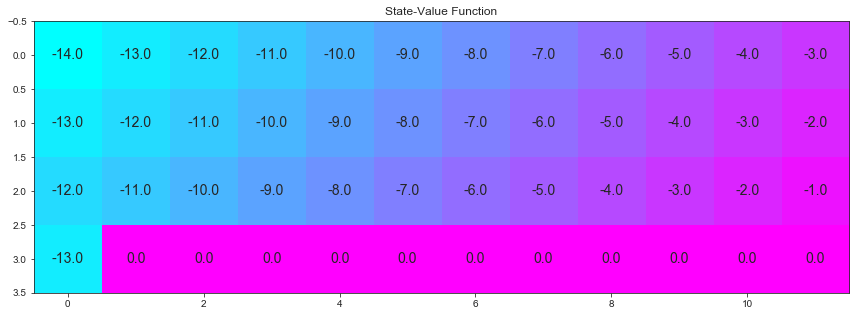

In [4]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [50]:
def epsilon_greedy(Q, state, nA, eps ):
    
    if random.random() > eps: # select greedy action with probability epsilon
        return np.argmax(Q[state])
    else:                     # otherwise, select an action randomly
        return random.choice(np.arange(env.action_space.n))
   
    
    
def update_QTable_using_SARSA(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    current_value = Q[state][action]
    if next_state is not None:
        next_state_action_reward = Q[next_state][next_action]
    else: 
        next_state_action_reward  = 0
    
    target = reward + gamma * (next_state_action_reward)
    
    new_reward = current_value + alpha * (target - current_value)
    return new_reward
    

In [57]:
def sarsa(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    # initialize action-value function (empty dictionary of arrays)
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    # monitor performance
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        score = 0 
        state = env.reset()
        eps = 1.0/ i_episode
        action = epsilon_greedy(Q, state, nA,eps )
        
        while True: 
            next_state, reward, done, info = env.step(action) # take action A, observe R, S'
            score += reward
            
            if not done:
                next_action = epsilon_greedy(Q, next_state, nA,eps )
                Q[state][action] = update_QTable_using_SARSA(alpha, gamma, Q, state, action,\
                                                             reward, next_state, next_action)
                state = next_state
                action = next_action
            else:
                Q[state][action] = update_QTable_using_SARSA(alpha, gamma, Q, \
                                                            state, action, reward)
                tmp_scores.append(score)    # append score
                break
                
       # print("\n Dumping the tmp_scores . length is {0} and values are \n {1}".format(len(tmp_scores), tmp_scores))
        if (i_episode % plot_every == 0):
         #   print("Avg tmp_scores and append to avg_score")
         #   print("Before: {0}".format(avg_scores))
            avg_scores.append(np.mean(tmp_scores))
         #   print("After: {0}".format(avg_scores))

   # print("\n Dumping the avg_scores . length is {0} and values are \n {1}".format(len(avg_scores), avg_scores))
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))    
    print("\n The QTable is : \n")
    for key,value in Q.items():
        print("Key :{0} and value: {1}".format(key,value))
    return Q
        


Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

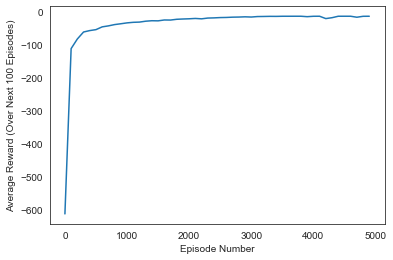

Best Average Reward over 100 Episodes:  -13.0

 The QTable is : 

Key :36 and value: [ -13.04007953 -119.16623318  -35.35088045  -30.35336956]
Key :24 and value: [-12.41839069 -12.04370541 -22.00438763 -12.4359474 ]
Key :12 and value: [-11.61619664 -11.61811593 -11.61672669 -11.62845899]
Key :13 and value: [-10.83709378 -10.83519947 -10.84220597 -10.84234605]
Key :1 and value: [-10.6029215  -10.5885264  -10.59474591 -10.59093286]
Key :0 and value: [-11.12896607 -11.12497122 -11.13840636 -11.12397025]
Key :25 and value: [-11.06226487 -11.03730283 -51.76173137 -11.06292937]
Key :26 and value: [-10.14283226 -10.01802653 -25.59959889 -10.14761653]
Key :14 and value: [-10.03503312 -10.03123955 -10.0307771  -10.03693585]
Key :15 and value: [-9.1983568  -9.18977633 -9.19474158 -9.19179675]
Key :27 and value: [ -9.03810688  -9.00466406 -23.47095588  -9.03668787]
Key :16 and value: [-8.34124659 -8.33502282 -8.33727115 -8.35032935]
Key :28 and value: [ -8.08535696  -8.00836573 -12.60479276  -8.1

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 3  1  1  1  2  3  1  2  1  2  1  2]
 [ 0  1  2  1  1  1  1  1  2  0  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


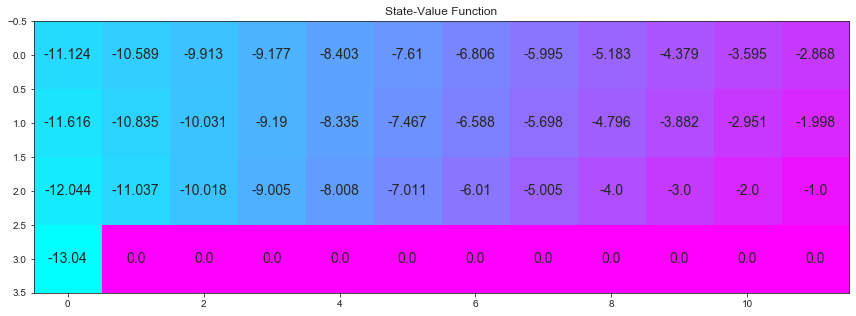

In [58]:
# obtain the estimated optimal policy and corresponding action-value function

Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

In [59]:
policy_sarsa = ([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)])
print("policy sarsa : \n {0}".format(policy_sarsa))

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
print("V sarsa : \n {0}".format(V_sarsa))


policy sarsa : 
 [3, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 0, 1, 2, 1, 1, 1, 1, 1, 2, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
V sarsa : 
 [-11.123970245197876, -10.588526403726842, -9.913305125582733, -9.176824068084043, -8.40317694193676, -7.609686117055404, -6.805720590942865, -5.9945258354661695, -5.183447233645918, -4.379309228609241, -3.594824611777049, -2.867873769105195, -11.616196643635957, -10.835199466128572, -10.030777095566286, -9.189776328551623, -8.335022824710144, -7.467262755403748, -6.588412985745061, -5.697801347145464, -4.796472471769716, -3.8819006208432523, -2.9509509200599204, -1.9983734279726366, -12.043705405185234, -11.037302826673962, -10.018026526741833, -9.004664060250517, -8.008365726195965, -7.01139010415057, -6.010305733560852, -5.004645221781231, -4.0000080137190155, -3.0000028283417506, -2.0000005040552966, -0.9999999999999944, -13.040079533007008, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [66]:
def epsilon_greedy_q_learning(Q, state, nA, eps):
    if random.random() > eps:
        return np.argmax(Q[state])
    else:
        return random.choice(np.arange(nA))
    

def update_Q_QLearning(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    current_state = Q[state][action]
    
    if next_state is not None:
        next_reward = np.max(Q[next_state])
    else: 
        next_reward = 0 
    
    target = reward + gamma * next_reward
    
    new_reward_curr_state = current_state + alpha * (target - current_state)
    
    return new_reward_curr_state

In [69]:
def q_learning(env, num_episodes, alpha, gamma=1.0,plot_every=100):
    
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    #quques to track tmp and avg scores
    tmp_scores = deque(maxlen = plot_every)
    avg_scores = deque(maxlen = num_episodes)
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        score = 0 
        state = env.reset()
        
        eps = 1.0 / i_episode
    
        while True: 
            action = epsilon_greedy_q_learning(Q, state, nA, eps)
            next_state, reward, done, info = env.step(action)
            score += reward
            
            Q[state][action] = update_Q_QLearning(alpha, gamma, Q, state, \
                                                     action, reward,next_state)
            state = next_state
            if done:
                tmp_scores.append(score)
                break
                
            
        if i_episode % plot_every == 0:
            avg_scores.append(np.mean(tmp_scores))
        
    #Plot Performance
    plt.plot(np.linspace(0,num_episodes, len(avg_scores), endpoint=False), np.asarray(avg_scores))
    plt.xlabel("Number of Episodes")
    plt.ylabel("Avg Reward every {0} episode".format(plot_every))
    plt.show()
            
        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

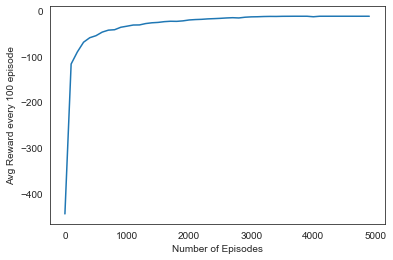

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 2  0  3  1  2  0  1  1  0  0  2  0]
 [ 0  2  0  1  2  1  2  1  0  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


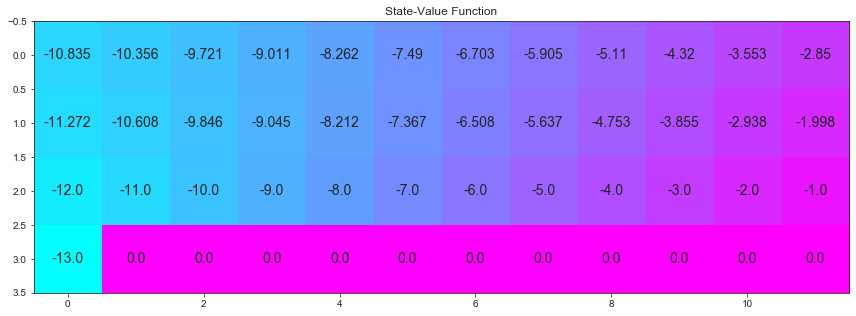

In [70]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [102]:
def update_Q_expected_sarsa(alpha, gamma, Q, nA, eps, state,action, reward, next_state=None):
    print("The state is : {0}".format(state))
    print("The action  is : {0}".format(action))
    current = Q[state][action]

    policy_s = get_probs(Q_s, eps, nA)
    Qsa_next = np.dot(Q[next_state] , policy_s)
    
    target = reward + gamma * Qsa_next
    
    new_value = current + (alpha * (target - current))
    
    return new_value
    
    

def get_probs(Q, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    greedy_action = np.argmax(Q)
    policy_s[greedy_action] = 1 - epsilon + (epsilon / nA)
    return policy_s

In [103]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0,plot_every=100):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    tmp_scores = deque(maxlen=plot_every)
    avg_scores = deque(maxlen=num_episodes)
    
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
 
        eps = 0.05
        state = env.reset()
        score = 0 

                
        while True:
            action = epsilon_greedy(Q, state, env.nA, eps )
            
            next_state, reward, done, info = env.step(action)
            score += reward
            Q[state][action] = update_Q_expected_sarsa(alpha, gamma, Q, nA, eps, state,action, reward, next_state)
            state = next_state
            
            if done:
                tmp_scores.append(score)    # append score
                break
                
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
            
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 10000/10000

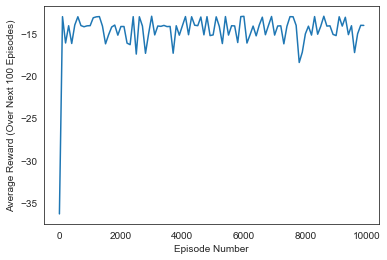

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  3  3  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


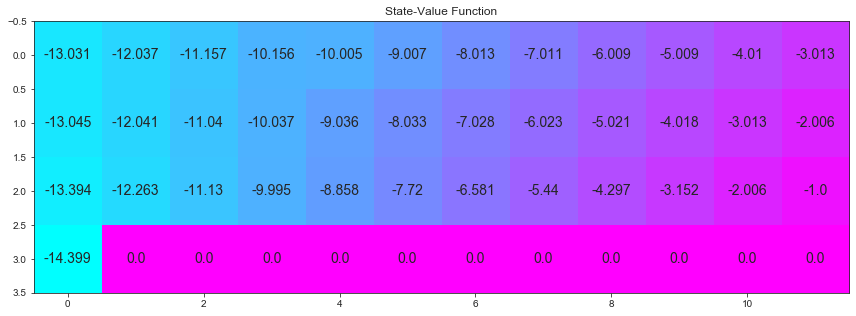

In [104]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa_2(env, 10000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])